In [13]:
# # Code to convert this notebook to .py if you want to run it via command line or with Slurm
# from subprocess import call
# command = "jupyter nbconvert Reconstruction_Metrics.ipynb --to python"
# call(command,shell=True)

[NbConvertApp] Converting notebook Reconstruction_Metrics.ipynb to python
[NbConvertApp] Writing 10995 bytes to Reconstruction_Metrics.py


0

In [2]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm import tqdm
from datetime import datetime
import argparse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
seed=42
utils.seed_everything(seed=seed)

if utils.is_interactive():
    %load_ext autoreload
    %autoreload 2

from models import Clipper
clip_extractor = Clipper("ViT-L/14", hidden_state=False, norm_embs=True, device=device)
imsize = 512

device: cuda
ViT-L/14 cuda


# Configurations

In [3]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    # Example use
    jupyter_args = "--recon_path=prior_257_final_subj01_bimixco_softclip_byol_brain_recons_full_img2img0.85_16samples.pt"
    
    jupyter_args = jupyter_args.split()
    print(jupyter_args)
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    %autoreload 2 # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions

['--recon_path=prior_257_final_subj01_bimixco_softclip_byol_brain_recons_full_img2img0.85_16samples.pt']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--recon_path", type=str,
    help="path to reconstructed/retrieved outputs",
)
parser.add_argument(
    "--all_images_path", type=str, default="all_images.pt",
    help="path to ground truth outputs",
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)

In [7]:
all_brain_recons = torch.load(f'{recon_path}')
all_images = torch.load(f'{all_images_path}')

print(all_images.shape)
print(all_brain_recons.shape)

all_images = all_images.to(device)
all_brain_recons = all_brain_recons.to(device).to(all_images.dtype).clamp(0,1)

torch.Size([982, 3, 256, 256])
torch.Size([982, 3, 512, 512])


# Display reconstructions next to ground truth images

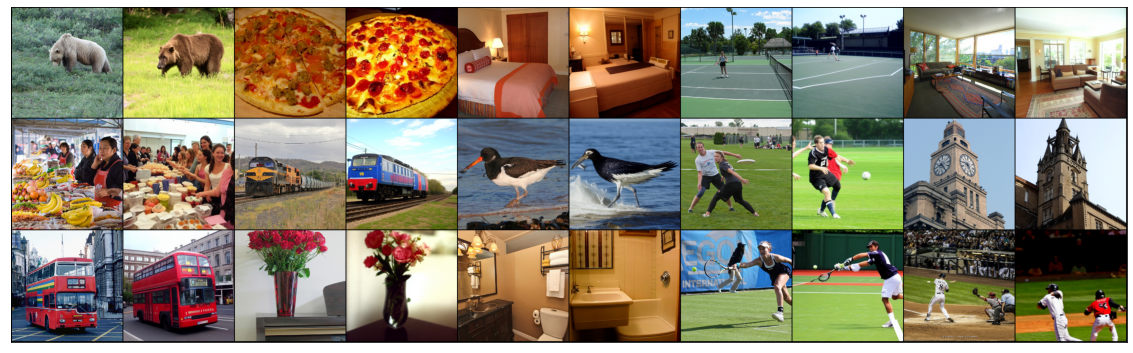

In [12]:
imsize = 256
all_images = transforms.Resize((imsize,imsize))(all_images)
all_brain_recons = transforms.Resize((imsize,imsize))(all_brain_recons)

np.random.seed(0)
ind = np.flip(np.array([112,119,101,44,159,22,173,174,175,189,981,243,249,255,265]))

all_interleaved = torch.zeros(len(ind)*2,3,imsize,imsize)
icount = 0
for t in ind:
    all_interleaved[icount] = all_images[t]
    all_interleaved[icount+1] = all_brain_recons[t]
    icount += 2

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs,figsize):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.ToPILImage()(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
grid = make_grid(all_interleaved, nrow=10, padding=2)
show(grid,figsize=(20,16))

# 2-Way Identification

In [53]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

@torch.no_grad()
def two_way_identification(all_brain_recons, all_images, model, preprocess, feature_layer=None, return_avg=True):
    preds = model(torch.stack([preprocess(recon) for recon in all_brain_recons], dim=0).to(device))
    reals = model(torch.stack([preprocess(indiv) for indiv in all_images], dim=0).to(device))
    if feature_layer is None:
        preds = preds.float().flatten(1).cpu().numpy()
        reals = reals.float().flatten(1).cpu().numpy()
    else:
        preds = preds[feature_layer].float().flatten(1).cpu().numpy()
        reals = reals[feature_layer].float().flatten(1).cpu().numpy()

    r = np.corrcoef(reals, preds)
    r = r[:len(all_images), len(all_images):]
    congruents = np.diag(r)

    success = r < congruents
    success_cnt = np.sum(success, 0)

    if return_avg:
        perf = np.mean(success_cnt) / (len(all_images)-1)
        return perf
    else:
        return success_cnt, len(all_images)-1

## PixCorr

In [54]:
preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR),
])

# Flatten images while keeping the batch dimension
all_images_flattened = preprocess(all_images).reshape(len(all_images), -1).cpu()
all_brain_recons_flattened = preprocess(all_brain_recons).view(len(all_brain_recons), -1).cpu()

print(all_images_flattened.shape)
print(all_brain_recons_flattened.shape)

corrsum = 0
for i in tqdm(range(982)):
    corrsum += np.corrcoef(all_images_flattened[i], all_brain_recons_flattened[i])[0][1]
corrmean = corrsum / 982

pixcorr = corrmean
print(pixcorr)

/fsx/home-paulscotti/miniconda3/envs/medical-v1/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([982, 541875])
torch.Size([982, 541875])


100%|███████████████████████████████████████████████████████████████████████████████████████████| 982/982 [00:05<00:00, 188.06it/s]

0.2087031825550804


## SSIM

In [55]:
# see https://github.com/zijin-gu/meshconv-decoding/issues/3
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim

preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR), 
])

# convert image to grayscale with rgb2grey
img_gray = rgb2gray(preprocess(all_images).permute((0,2,3,1)).cpu())
recon_gray = rgb2gray(preprocess(all_brain_recons).permute((0,2,3,1)).cpu())
print("converted, now calculating ssim...")

ssim_score=[]
for im,rec in tqdm(zip(img_gray,recon_gray),total=len(all_images)):
    ssim_score.append(ssim(rec, im, multichannel=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=1.0))

ssim = np.mean(ssim_score)
print(ssim)

converted, now calculating ssim...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 982/982 [00:13<00:00, 72.90it/s]

0.3015735580149633


### AlexNet

In [56]:
from torchvision.models import alexnet, AlexNet_Weights
alex_weights = AlexNet_Weights.IMAGENET1K_V1

alex_model = create_feature_extractor(alexnet(weights=alex_weights), return_nodes=['features.4','features.11']).to(device)
alex_model.eval().requires_grad_(False)

# see alex_weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

layer = 'early, AlexNet(2)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_brain_recons.to(device).float(), all_images, 
                                                          alex_model, preprocess, 'features.4')
alexnet2 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet2:.4f}")

layer = 'mid, AlexNet(5)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_brain_recons.to(device).float(), all_images, 
                                                          alex_model, preprocess, 'features.11')
alexnet5 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet5:.4f}")


---early, AlexNet(2)---
2-way Percent Correct: 0.8829

---mid, AlexNet(5)---
2-way Percent Correct: 0.9312


### InceptionV3

In [57]:
from torchvision.models import inception_v3, Inception_V3_Weights
weights = Inception_V3_Weights.DEFAULT
inception_model = create_feature_extractor(inception_v3(weights=weights), 
                                           return_nodes=['avgpool']).to(device)
inception_model.eval().requires_grad_(False)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(342, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

all_per_correct = two_way_identification(all_brain_recons, all_images,
                                        inception_model, preprocess, 'avgpool')
        
inception = np.mean(all_per_correct)
print(f"2-way Percent Correct: {inception:.4f}")

/fsx/home-paulscotti/miniconda3/envs/medical-v1/lib/python3.10/site-packages/torchvision/models/feature_extraction.py:174: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)


2-way Percent Correct: 0.8758


### CLIP

In [58]:
import clip
clip_model, preprocess = clip.load("ViT-L/14", device=device)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])

all_per_correct = two_way_identification(all_brain_recons, all_images,
                                        clip_model.encode_image, preprocess, None) # final layer
clip_ = np.mean(all_per_correct)
print(f"2-way Percent Correct: {clip_:.4f}")

2-way Percent Correct: 0.8867


### Efficient Net

In [59]:
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
weights = EfficientNet_B1_Weights.DEFAULT
eff_model = create_feature_extractor(efficientnet_b1(weights=weights), 
                                    return_nodes=['avgpool']).to(device)
eff_model.eval().requires_grad_(False)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(255, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

gt = eff_model(preprocess(all_images))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()
fake = eff_model(preprocess(all_brain_recons))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

effnet = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
print("Distance:",effnet)

Distance: 0.7269443141325491


### SwAV

In [60]:
swav_model = torch.hub.load('facebookresearch/swav:main', 'resnet50')
swav_model = create_feature_extractor(swav_model, 
                                    return_nodes=['avgpool']).to(device)
swav_model.eval().requires_grad_(False)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

gt = swav_model(preprocess(all_images))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()
fake = swav_model(preprocess(all_brain_recons))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

swav = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
print("Distance:",swav)

Using cache found in /admin/home-paulscotti/.cache/torch/hub/facebookresearch_swav_main
/fsx/home-paulscotti/miniconda3/envs/medical-v1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/fsx/home-paulscotti/miniconda3/envs/medical-v1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Distance: 0.4273955492253459


# Display in table

In [61]:
# Create a dictionary to store variable names and their corresponding values
data = {
    "Metric": ["PixCorr", "SSIM", "AlexNet(2)", "AlexNet(5)", "InceptionV3", "CLIP", "EffNet-B", "SwAV"],
    "Value": [pixcorr, ssim, alexnet2, alexnet5, inception, clip_, effnet, swav],
}

df = pd.DataFrame(data)
print(model_name)
print(df.to_string(index=False))

if not utils.is_interactive():
    # save table to txt file
    df.to_csv(f'{recon_path}.txt', sep='\t', index=False)

prior_257_final_subj07_bimixco_softclip_byol_brain_recons_full_img2img0.85_16samples_singletrial
     Metric    Value
    PixCorr 0.208703
       SSIM 0.301574
 AlexNet(2) 0.882889
 AlexNet(5) 0.931168
InceptionV3 0.875822
       CLIP 0.886660
   EffNet-B 0.726944
       SwAV 0.427396
